In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as B
from scipy.linalg import solve, solve_banded
from math import *
import time
plt.style.use(r'customStyle.mplstyle')

# functions \xi**{2m+1} (1 - \xi)**n sin((2m+1) \phi)
# scalar product < m n | m' n'> = (m==m') * pi/2 * B(4 + 4m, 1 + n + n')

# matrix A = (m == m') * (-pi/2) * (n * n' * (3+4*m))/(2+4*m+n+n') * B(n+n'-1, 3+4*m)
# vector b = - 2/(2m' + 1) * B(2m'+3, n'+1)

M = 20
N = 20



In [22]:
def run(M, N):
    print('Uporabljena M, N:', M, N)
    times = []
    Cs = []

    time0 = time.time()
    A = np.zeros((M * N, M * N))
    for m in range(M):
        for m0 in range(M):
            # Create a block for every m, m0 combination
            if m != m0:
                continue
            else:
                for n in range(N):
                    for n0 in range(N):
                        A[m * N + n, m0 * N + n0] = - pi/2 * \
                            ((n+1) * (n0+1) * (3 + 4*m)) / \
                            (4 + 4*m + n + n0) * B(n + n0 + 1, 3 + 4*m)
    time1 = time.time()
    time_A = time1-time0
    times.append(time_A)
    print('Create A matrix', time_A)

    # Make A in banded format
    time0 = time.time()
    ab = np.zeros((2 * N - 1, M * N))
    for i in range(M * N):
        for j in range(max(0, i - N + 1), min(M * N, i + N)):
            m, n = divmod(i, N)
            m0, n0 = divmod(j, N)
            if m == m0:
                ab[N - 1 + i - j, j] = - pi/2 * \
                    ((n+1) * (n0+1) * (3 + 4*m)) / \
                    (4 + 4*m + n + n0) * B(n + n0 + 1, 3 + 4*m)
    time1 = time.time()
    time_Aband = time1 - time0
    times.append(time_Aband)
    print('Create A banded:', time_Aband)

    time0 = time.time()
    A_inv = np.linalg.inv(A)
    time1 = time.time()
    time_Ainv = time1 - time0
    times.append(time_Ainv)
    print('invert A:', time_Ainv)

    time0 = time.time()
    b = np.zeros((M*N))
    for m0 in range(M):
        for n0 in range(N):
            b[m0 * N + n0] = - 2 / (2*m0 + 1) * B(2*m0 + 3, n0 + 2)
    time1 = time.time()
    time_b = time1-time0
    times.append(time_b)
    print('Create b vector', time_b)

    time0 = time.time()
    a, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    C_lstsq = - 32/pi * a@b
    time1 = time.time()
    time_lstsq = time1 - time0
    times.append(time_lstsq)
    Cs.append(C_lstsq)
    print('lstsq time:', time_lstsq)
    print('lstsq', C_lstsq)

    time0 = time.time()
    a = np.linalg.solve(A, b)
    C_np = - 32/pi * a@b
    time1 = time.time()
    time_np = time1 - time0
    times.append(time_np)
    Cs.append(C_np)
    print('numpy time:', time_np)
    print('np solve', C_np)

    time0 = time.time()
    a = solve(A, b)
    C_solve = - 32/pi * a@b
    time1 = time.time()
    time_solve = time1-time0
    times.append(time_solve)
    Cs.append(C_solve)
    print('solve time:', time_solve)
    print('solve', C_solve)

    time0 = time.time()
    a = solve_banded((N - 1, N - 1), ab, b)
    C_band = - 32/pi * a@b
    time1 = time.time()
    time_solve_banded = time1 - time0
    times.append(time_solve_banded)
    Cs.append(C_band)
    print('solve banded time:', time_solve_banded)
    print('banded', C_band)

    time0 = time.time()
    C_inv = - 32/pi * b @ (A_inv @ b)
    time1 = time.time()
    time_solve_inverted = time1 - time0
    times.append(time_solve_inverted)
    Cs.append(C_inv)
    print('solve inverted time:', time_solve_inverted)
    print('inverse', C_inv)

    print('----------------------------------')
    return np.array(times), np.array(Cs)


In [ ]:
# time0 = time.time()
# times, Cs = run(5, 50)
# time1 = time.time()
# print(times)
# print(Cs)
# print(time1-time0)

meta_times = {}
meta_Cs = {}
for M in range(10, 101, 10):
    for N in range(10, 101, 10):
        meta_times[(M, N)] = []
        meta_Cs[(M, N)] = []

        for i in range(1):
            times, Cs = run(M, N)
            meta_times[(M, N)].append(times)
            meta_Cs[(M, N)].append(Cs)

        meta_times[(M, N)] = np.array(meta_times[(M, N)])
        meta_Cs[(M, N)] = np.array(meta_Cs[(M, N)])


(100, 1) (100, 1) (100, 1)


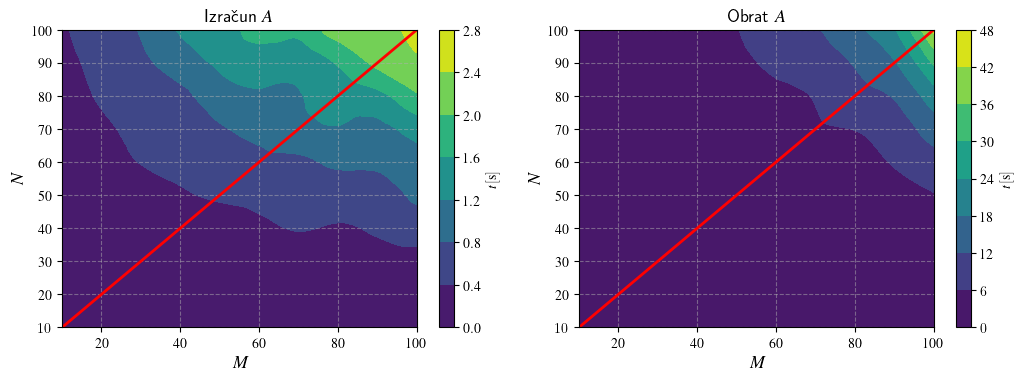

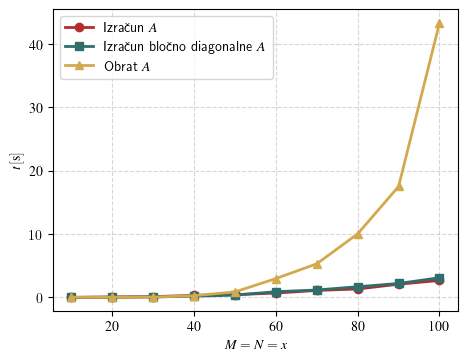

In [157]:
# Časovna zahtevnost priprave matrik
times_A = []
times_Aband = []
times_Ainv = []
xy_plane = []

for M in range(10, 101, 10):
    for N in range(10, 101, 10):
        xy_plane.append([M, N])
        usable = meta_times[(M, N)][:, :3]
        times_A.append(usable[:, 0])
        times_Aband.append(usable[:, 1])
        times_Ainv.append(usable[:, 2])

times_A = np.array(times_A)
times_Aband = np.array(times_Aband)
times_Ainv = np.array(times_Ainv)
print(times_A.shape, times_Aband.shape, times_Ainv.shape)

mean_times_A = np.mean(times_A, axis=1)
mean_times_Aband = np.mean(times_Aband, axis=1)
mean_times_Ainv = np.mean(times_Ainv, axis=1)

sterr_times_A = np.std(times_A, axis=1) / sqrt(10)

# print(mean_times_A)
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

xy_plane = np.array(xy_plane)
X, Y = xy_plane[:, 0], xy_plane[:, 1]
Z = mean_times_A

# Create grid data for interpolation
grid_x, grid_y = np.mgrid[10:100:100j, 10:100:100j]
grid_z = griddata((X, Y), Z, (grid_x, grid_y), method='cubic')

fig, axs = plt.subplots(1, 2, figsize=(5.225*2, 3.919))

# Plot for times_A
Z = mean_times_A
grid_z = griddata((X, Y), Z, (grid_x, grid_y), method='cubic')
contour = axs[0].contourf(grid_x, grid_y, grid_z, cmap='viridis')
axs[0].plot([10, 100], [10, 100], 'r-', linewidth=2)  # Add red line
axs[0].set_title('Izračun $A$', fontsize=13)
axs[0].set_xlabel(r'$M$', fontsize=13)
axs[0].set_ylabel(r'$N$', fontsize=13)
fig.colorbar(contour, ax=axs[0], label=r'$t [\si{\second}]$')

# Plot for times_Ainv
Z = mean_times_Ainv
grid_z = griddata((X, Y), Z, (grid_x, grid_y), method='cubic')
contour = axs[1].contourf(grid_x, grid_y, grid_z, cmap='viridis')
axs[1].plot([10, 100], [10, 100], 'r-', linewidth=2)  # Add red line
axs[1].set_title('Obrat $A$', fontsize=13)
axs[1].set_xlabel(r'$M$', fontsize=13)
axs[1].set_ylabel(r'$N$', fontsize=13)
fig.colorbar(contour, ax=axs[1], label=r'$t [\si{\second}]$')

plt.tight_layout()
plt.savefig(r'times_comparison.pdf')
plt.show()

# 1D plot of N=M=x vs each of the times
fig, ax = plt.subplots()
x = np.arange(10, 101, 10)
ax.plot(x, mean_times_A[::11], label='Izračun $A$', marker='o')
ax.plot(x, mean_times_Aband[::11], label='Izračun bločno diagonalne $A$', marker='s')
ax.plot(x, mean_times_Ainv[::11], label='Obrat $A$', marker='^')
ax.set_xlabel(r'$M = N = x$')
ax.set_ylabel(r'$t [\si{\second}]$')
ax.legend()
# plt.yscale('log')
plt.savefig(r'times_1d_comparison.pdf')
plt.show()



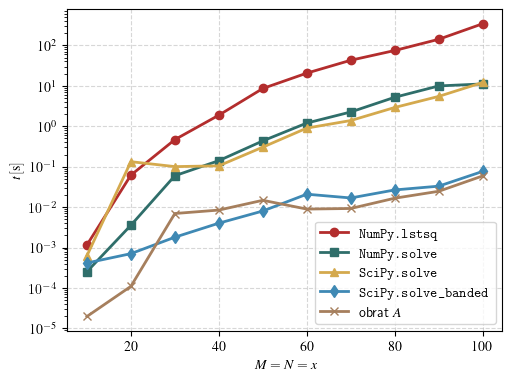

In [166]:
# Časovna zahtevnost priprave matrik
times_lstsq = []
times_np = []
times_solve = []
times_band = []
times_inverted = []


for M in range(10, 101, 10):
    for N in range(10, 101, 10):
        usable = meta_times[(M, N)][:, 4:]
        times_lstsq.append(usable[:, 0])
        times_np.append(usable[:, 1])
        times_solve.append(usable[:, 2])
        times_band.append(usable[:, 3])
        times_inverted.append(usable[:, 4])


# 1D plot of N=M=x vs each of the times in log scale
fig, ax = plt.subplots()
x = np.arange(10, 101, 10)

# Extract the times for each method when M = N = x
mean_times_lstsq = np.array([np.mean(times_lstsq[i]) for i in range(0, len(times_lstsq), 11)])
mean_times_np = np.array([np.mean(times_np[i]) for i in range(0, len(times_np), 11)])
mean_times_solve = np.array([np.mean(times_solve[i]) for i in range(0, len(times_solve), 11)])
mean_times_band = np.array([np.mean(times_band[i]) for i in range(0, len(times_band), 11)])
mean_times_inverted = np.array([np.mean(times_inverted[i]) for i in range(0, len(times_inverted), 11)])

# Plot each method
ax.plot(x, mean_times_lstsq, label=r'\texttt{NumPy.lstsq}', marker='o')
ax.plot(x, mean_times_np, label=r'\texttt{NumPy.solve}', marker='s')
ax.plot(x, mean_times_solve, label=r'\texttt{SciPy.solve}', marker='^')
ax.plot(x, mean_times_band, label=r'\texttt{SciPy.solve_banded}', marker='d')
ax.plot(x, mean_times_inverted, label=r'obrat $A$', marker='x')

ax.set_xlabel(r'$M = N = x$')
ax.set_ylabel(r'$t [\si{\second}]$')
ax.legend()
plt.yscale('log')
plt.tight_layout()
plt.savefig(r'methods_1d.pdf')
plt.show()


(100, 1, 5)
0.7577218345216044
(10,)
(10,)


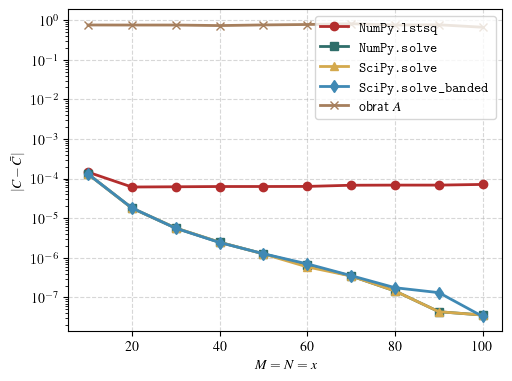

In [ ]:
# Časovna zahtevnost priprave matrik
results = []

for M in range(10, 101, 10):
    for N in range(10, 101, 10):
        results.append(meta_Cs[(M, N)])
results = np.array(results)

print(results.shape) # (100, 1, 5)
# Extract the mean values for each method when M = N = x
# mean_Cs = np.mean(results[:, 0, :], axis=0)
mean_CS = np.median(results[-2:, :, :])
print(mean_CS)

# Plot each method
fig, ax = plt.subplots()
x = 10 * np.arange(1, 11)  # Adjust x to match the shape of mean_Cs
print(x.shape)
print(results[::11, :, 0][:, 0].shape)
ax.plot(x, abs(mean_CS - results[::11, :, 0][:, 0]), label=r'\texttt{NumPy.lstsq}', marker='o')
ax.plot(x, abs(mean_CS - results[::11, :, 1][:, 0]), label=r'\texttt{NumPy.solve}', marker='s')
ax.plot(x, abs(mean_CS - results[::11, :, 2][:, 0]), label=r'\texttt{SciPy.solve}', marker='^')
ax.plot(x, abs(mean_CS - results[::11, :, 3][:, 0]), label=r'\texttt{SciPy.solve_banded}', marker='d')
ax.plot(x, results[::11, :, 4][:, 0], label=r'obrat $A$', marker='x')

ax.set_xlabel(r'$M = N = x$')
ax.set_ylabel(r'$|C - \bar{C}|$')
ax.legend()
plt.yscale('log')
plt.tight_layout()
# plt.savefig(r'Cs_1d_comparison.pdf')
plt.show()

In [97]:
meta_times1 = meta_times